In [1]:
import numpy as np
import pandas as pd

In [12]:
# загрузка
link_to_data = 'https://raw.githubusercontent.com/aiedu-courses/eda_and_dev_tools/main/datasets/abalone.csv '
try:
    df = pd.read_csv(link_to_data)
    print("Файл успешно загружен!")
except Exception as e:
    print("Ошибка при загрузке файла:", e)

Файл успешно загружен!


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# обработка опечаток в категориях
df['Sex'] = df['Sex'].str.upper()
assert set(df['Sex'].unique()) == {'M', 'F', 'I'}, "Проверка не прошла!"

# Удаление выбросов в колонке Height Методом межквартильного размаха (IQR)
Q1 = df['Height'].quantile(0.25)
Q3 = df['Height'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Height'] >= lower_bound) & (df['Height'] <= upper_bound)]

# Целевая переменная (теперь это 'Rings')
target_column = 'Rings'
# Разделение на числовые и категориальные признаки
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
numeric_columns = [col for col in numeric_columns if col != target_column]
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

# Заполнение пропусков в числовых столбцах медианой
for col in numeric_columns:
    median_value = df[col].median()
    df[col].fillna(median_value, inplace=True)

In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [16]:
# Препроцессор
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Rings'])
y_rings = df['Rings']
# Разделение выборки
X_train_reg, X_test_reg, y_train_rings, y_test_rings = train_test_split(X, y_rings, test_size=0.25, random_state=42)

# Пайплайн
pipe_reg = Pipeline(steps=[('preprocessor', preprocessor), ('model', LGBMRegressor(random_state=42))])

# Обучение
pipe_reg.fit(X_train_reg, y_train_rings)

# Предсказания
y_pred_rings = pipe_reg.predict(X_test_reg)
y_pred_rounded = np.round(y_pred_rings)  # Округляем до целых колец

# Метрики
mae = mean_absolute_error(y_test_rings, y_pred_rounded)
r2 = r2_score(y_test_rings, y_pred_rounded)

print(f"Целочисленная регрессия (округлённая): MAE={mae:.4f}, R²={r2:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1284
[LightGBM] [Info] Number of data points in the train set: 3111, number of used features: 10
[LightGBM] [Info] Start training from score 9.966892
Целочисленная регрессия (округлённая): MAE=1.531, R²=0.513


In [32]:
from explainerdashboard import RegressionExplainer, ExplainerDashboard

# Получаем обработанные данные как DataFrame с правильными названиями признаков
X_test_processed_df = pd.DataFrame(
    pipe_reg.named_steps['preprocessor'].transform(X_test_reg),
    columns=pipe_reg.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_columns).tolist() + numeric_columns
)

# Создаём объяснителя
reg_explainer = RegressionExplainer(
    model=pipe_reg.named_steps['model'],
    X=X_test_processed_df,
    y=y_test_rings,
)

# Создаём dashboard
db = ExplainerDashboard(reg_explainer, title="Abalone Rings Regressor")

# Сохраняем конфигурацию дашборда
db.to_yaml("abalone_regression_dashboard.yaml", explainerfile="regression_explainer.joblib", dump_explainer=True)

print("✅ ExplainerDashboard успешно сохранён!")

Generating self.shap_explainer = shap.TreeExplainer(model)
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating shap interaction values...
Reminder: TreeShap computational complexity is O(TLD^2), where T is the number of trees, L is the maximum number of leaves in any tree and D the maximal depth of any tree. So reducing these will speed up the calculation.
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks.

In [42]:
from explainerdashboard import ExplainerDashboard

db = ExplainerDashboard(reg_explainer)
db.save_html("abalone_regression_report.html")

print("✅ HTML-отчет создан: abalone_regression_report.html")

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
✅ HTML-отчет создан: abalone_regression_report.html


In [34]:
from explainerdashboard import ExplainerDashboard

db = ExplainerDashboard.from_config("abalone_regression_dashboard.yaml")
db.run(host='0.0.0.0', port=8050, use_waitress=True)

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating dependencies...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://192.168.50.79:8050


Пример прогноза:


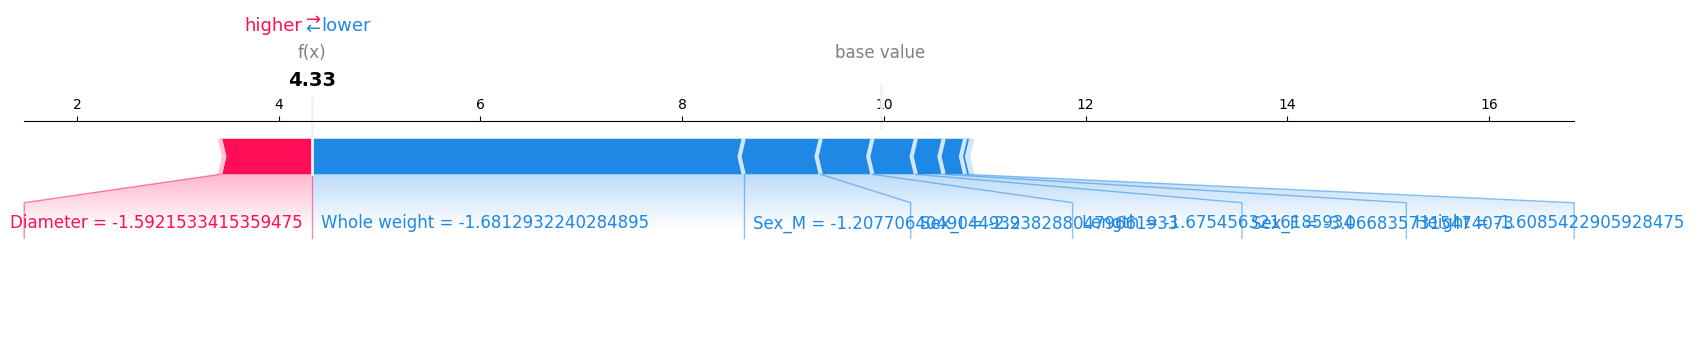

In [37]:
import shap
import matplotlib.pyplot as plt

# Объясняем модель
explainer_shap = shap.TreeExplainer(pipe_reg.named_steps['model'])
shap_values = explainer_shap.shap_values(pipe_reg.named_steps['preprocessor'].transform(X_test_reg.iloc[[0]]))

# Выводим waterfall plot
print("Пример прогноза:")
shap.initjs()
shap.force_plot(explainer_shap.expected_value, shap_values[0], 
                pipe_reg.named_steps['preprocessor'].transform(X_test_reg.iloc[[0]]),
                feature_names=X_test_processed_df.columns,
                matplotlib=True, show=False)
plt.show()

In [23]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report

# Преобразуем Rings в строки для классификатора
y_class = y_rings.astype(str)

# Выборка
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_class, test_size=0.25, random_state=42)

# Пайплайн
pipe_clf = Pipeline(steps=[('preprocessor', preprocessor), ('model', CatBoostClassifier(verbose=0, random_state=42))])

# Обучение
pipe_clf.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf = pipe_clf.predict(X_test_clf)

# Метрики
acc = accuracy_score(y_test_clf, y_pred_clf)
print(f"\nКлассификация (28 классов): Accuracy = {acc:.3f}")
print(classification_report(y_test_clf, y_pred_clf))


Классификация (28 классов): Accuracy = 0.275
              precision    recall  f1-score   support

          10       0.25      0.32      0.28       154
          11       0.30      0.28      0.29       134
          12       0.14      0.11      0.12        65
          13       0.14      0.15      0.14        48
          14       0.15      0.05      0.08        37
          15       0.08      0.04      0.06        24
          16       0.11      0.05      0.07        21
          17       0.00      0.00      0.00         8
          18       0.00      0.00      0.00         7
          19       0.00      0.00      0.00         5
          20       0.00      0.00      0.00         6
          21       0.00      0.00      0.00         4
          22       0.00      0.00      0.00         3
          23       0.00      0.00      0.00         5
          24       0.00      0.00      0.00         1
          27       0.00      0.00      0.00         1
           3       0.00      0.00  

In [29]:
# Считаем, сколько примеров для каждого класса
df['Rings'].value_counts()

Rings
9     688
10    633
8     566
11    487
7     391
12    266
6     257
13    203
14    124
5     111
15    103
16     67
17     58
4      49
18     42
19     32
20     26
21     14
23      9
3       9
22      6
27      2
24      2
26      1
29      1
25      1
Name: count, dtype: int64